In [4]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

In [5]:
%presentation_style

In [6]:
%%capture

%set_random_seed 12

2025-03-22 14:00:40.244077: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 14:00:40.533747: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 14:00:42.097621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 14:00:42.097730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 14:00:42.201557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [7]:
%load_latex_macros


$\renewcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\renewcommand{\amax}{{\text{argmax}}}$
$\renewcommand{\P}{{\mathbb{P}}}$
$\renewcommand{\E}{{\mathbb{E}}}$
$\renewcommand{\R}{{\mathbb{R}}}$
$\renewcommand{\Z}{{\mathbb{Z}}}$
$\renewcommand{\N}{{\mathbb{N}}}$
$\renewcommand{\C}{{\mathbb{C}}}$
$\renewcommand{\abs}[1]{{ \left| #1 \right| }}$
$\renewcommand{\simpl}[1]{{\Delta^{#1} }}$


Extreme Value Theory for Anomaly Detection
<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [8]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging
import warnings
warnings.filterwarnings('ignore')

from celluloid import Camera
from IPython.core.display import HTML
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from typing import Protocol, Sequence, Union, Tuple, List, TypeVar, Callable

tfd = tfp.distributions

# Extreme Value Theory and Anomaly Detection

Ready to put your extreme value theory knowledge into practice? In the videos, you've learned the fundamentals of EVT and spotting unusual events hidden in your data. Now, these exercises are your chance to solidify those concepts and become a true anomaly detection expert!

Let us go through a quick example for fitting a GEV on data and extracting insight from it. For that we will use the NYC taxi calls dataset - a collection of taxi calls per 30-minutes intervals that was collected for over a year.

In [9]:
taxi_csv = os.path.join("..", 'data','nyc_taxi','nyc_taxi.csv')
taxi_df = pd.read_csv(taxi_csv)
# split time and date from timestamp
taxi_df['time'] = [x.time() for x in pd.to_datetime(taxi_df['timestamp'])]
taxi_df['date'] = [x.date() for x in pd.to_datetime(taxi_df['timestamp'])]
taxi_df.rename(columns={"value": "n_calls"}, inplace=True)
# drop timestamp as we extracted time and date already
taxi_df.drop(columns=["timestamp"], inplace=True)

In [10]:
taxi_df.head()

,n_calls,time,date
0,10844,00:00:00,2014-07-01
1,8127,00:30:00,2014-07-01
2,6210,01:00:00,2014-07-01
3,4656,01:30:00,2014-07-01
4,3820,02:00:00,2014-07-01


In [11]:
# Helper functions for normalizing data. In most cases, it will be enough to use the normalize function

def normalize_data(data: Sequence) -> np.ndarray:
    scaler = StandardScaler()
    return scaler.fit_transform(data)


def normalize_series(series: pd.Series) -> pd.DataFrame:
    # set no of rows dynamically as needed, use one column
    data = series.values.reshape(-1, 1)
    # remove one dimension, .reshape(-1) is shorthand for .reshape(n,)
    normalized_data = normalize_data(data).reshape(-1)
    return pd.Series(normalized_data, index=series.index)


def normalize_df(data_frame: pd.DataFrame):
    normalized_data = normalize_data(data_frame)
    return pd.DataFrame(normalized_data, columns=data_frame.columns, index=data_frame.index)


T = TypeVar("T")


def normalize(data: T) -> T:
    if isinstance(data, np.ndarray):
        return normalize_data(data)
    elif isinstance(data, pd.Series):
        return normalize_series(data)
    elif isinstance(data, pd.DataFrame):
        return normalize_df(data)
    else:
        raise ValueError(f"Unsupported data type: {data.__class__.__name__}")

In [12]:
taxi_df_normalized = taxi_df
taxi_df_normalized["n_calls"] = normalize(taxi_df_normalized["n_calls"])
taxi_df_normalized.head()

,n_calls,time,date
0,-0.618745,00:00:00,2014-07-01
1,-1.010291,00:30:00,2014-07-01
2,-1.286549,01:00:00,2014-07-01
3,-1.510496,01:30:00,2014-07-01
4,-1.630971,02:00:00,2014-07-01


We can define a trainable GEV with tensorflow probability as following

In [13]:
def get_gev(xi: float, mu=0., sigma=1., trainable_xi=True):
    xi, mu, sigma = np.array([xi, mu, sigma]).astype(float)
    if trainable_xi:
        xi = tf.Variable(xi, name="xi")

    # get the model, set loc, scale and concentration of the GEV distribution    
    return tfd.GeneralizedExtremeValue(
        loc=tf.Variable(mu, name='mu'),
        scale=tf.Variable(sigma, name='sigma'),
        concentration=xi,
     )

## Exercise: Playing with the GEV parameters

Plot the GEV probability distribution for different values of $\xi, \mu$ and $\sigma$. How do they differ qualitatively? 

What are the domains of definition of $z$ in the above analytic expression for $G(z)$? What values should the c.d.f. $G(z)$ take outside these domains and how does this affect fitting  $\xi, \mu, \sigma$ from data by maximum likelihood estimation?

What expression for the GEV do we get in the limit $\xi \longrightarrow 0$?

The three qualitatively different shapes of the GEV have their own names. For $\xi >0$ we get the [Fréchet Distribution](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distribution), for $\xi<0$ the reverse [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) and for $\xi=0$ the [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution). Note that using the Gumbel distribution in tensorflow probability is not exactly the same as using GEV with $\xi=0$ due to rounding errors. Try it out!

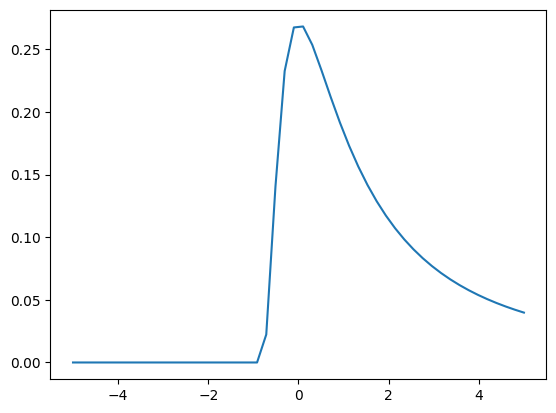

In [14]:
#gev = get_gev(xi=1e-5, sigma=2)
gev = get_gev(xi=1, mu=1, sigma=2, trainable_xi=False)

arr = np.linspace(-5, 5)

pdf = gev.prob(arr)
plt.plot(arr, pdf)
plt.show()

In [ ]:
import ipywidgets as widgets

def plot_function(xi, mu, sigma):
    gev = get_gev(xi, mu, sigma, trainable_xi=False)

    arr = np.linspace(-5, 5)

    pdf = gev.prob(arr)
    plt.plot(arr, pdf)
    plt.show()

xi_slider = widgets.FloatSlider(value=1e-5, min=-5, max=5, step=0.1, description='xi:')
mu_slider = widgets.FloatSlider(value=-1, min=-5, max=5, step=0.1, description='mu:')
sigma_slider = widgets.FloatSlider(value=2, min=-5, max=5, step=0.1, description='sigma:')

# Interactive display
widgets.interactive(plot_function, xi=xi_slider, mu=mu_slider, sigma=sigma_slider)

interactive(children=(FloatSlider(value=1e-05, description='xi:', max=5.0, min=-5.0), FloatSlider(value=-1.0, …

mu is shifting the curve <br>
sigma widens the curve or makes it more narrow

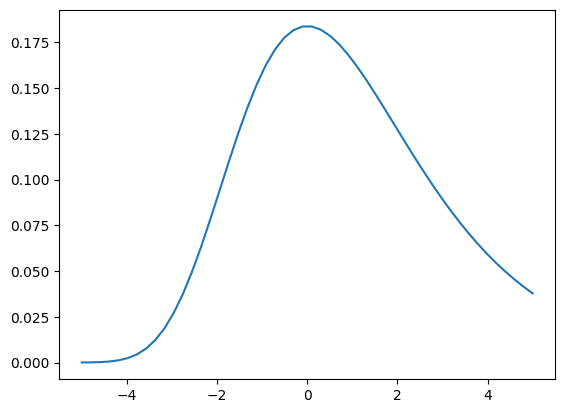

In [16]:
# Compare with Gumbel distribution
gumbel = tfp.distributions.Gumbel(
    0.,
    2.0,
    validate_args=False,
    allow_nan_stats=True,
    name='Gumbel'
)
arr = np.linspace(-5, 5)

pdf = gumbel.prob(arr)
plt.plot(arr, pdf)
plt.show()

## Solution: Playing with the GEV parameters

The cdf of the GEV distribution is well defined when $1 + \xi \left( \frac{z - \mu}{\sigma} \right) > 0$. This is equivalent to

$$
 z > \mu - \frac{\sigma}{\xi} \qquad \text{if $\xi>0$}
$$
and
$$
 z < \mu - \frac{|\sigma|}{\xi} \qquad \text{if $\xi<0$}.
$$

Thus, for $\xi>0$, the distribution has a left boundary, the probability of points lying to the left of it is zero. The value of the cdf there is zero.

For $\xi<0$ there is a right boundary, the probability of points lying to the right of it is zero and the value of the cdf is 1. 

As $\xi$ moves to zero from below, the right boundary is pushed to infinity. Similarly, if it approaches zero from above, the left boundary is pushed to negative infinity. At exactly $\xi=0$, the GEV becomes the Gumbel distribution which is well defined for all $z$.

We can group the numbers of calls according to the dates, thereby obtaining daily maxima and minima of calls. One way of detecting anomalies in the NYC taxi data set is by fitting a GEV to the distribution of these daily maxima. Here a histogram plot of the (normalized) maxima:

In [17]:
# aggregate n_calls by date with 3 grouping functions
daily_grouped = taxi_df.groupby("date")["n_calls"].agg(["max", "min", "sum"])

# add span between max and min
daily_grouped["diff"] = daily_grouped["max"] - daily_grouped["min"]
daily_grouped.head()

,max,min,sum,diff
date,,,,
2014-07-01,1.795669,-1.884028,2.790492,3.679696
2014-07-02,1.691045,-1.823358,1.014052,3.514403
2014-07-03,2.139658,-1.756635,-2.372237,3.896293
2014-07-04,0.481677,-1.709367,-25.080606,2.191043
2014-07-05,0.438732,-1.819178,-24.661968,2.257910


In [18]:
# normalize to mean = 0 and variance = 1
daily_grouped_normalized = normalize(daily_grouped)
daily_grouped_normalized.head()


,max,min,sum,diff
date,,,,
2014-07-01,0.960450,-0.714018,0.208709,1.261851
2014-07-02,0.718429,-0.155274,0.075844,0.838539
2014-07-03,1.756184,0.459211,-0.177427,1.816547
2014-07-04,-2.079144,0.894527,-1.875853,-2.550535
2014-07-05,-2.178485,-0.116786,-1.844541,-2.379291


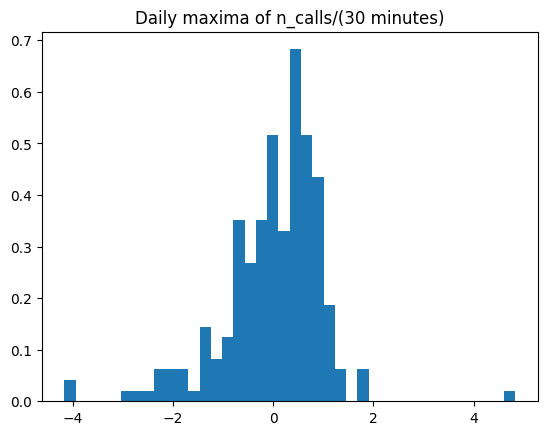

In [19]:
# Group normalized data into 40 bins to show the distribution
plt.hist(daily_grouped_normalized["max"], density=True, bins=40)
plt.title("Daily maxima of n_calls/(30 minutes)")
plt.show()

In [20]:
# print(daily_grouped_normalized[daily_grouped_normalized["max"] > 4])
# print(daily_grouped_normalized[daily_grouped_normalized["max"] < -4])

__Q__: Can you already spot the obvious anomalies? What caused them?

__A__: See below


__Q__: Which of the three qualitatively different shapes would make "physical" sense for the taxi calls data?

__A__: The Weibull shape - thus we expect $\xi<0$.

In [21]:
maxima = daily_grouped_normalized["max"]
maxima[(maxima > 1.8) | (maxima < -3.5)]

date
2014-09-06    1.885529
2014-11-02    4.827113
2014-12-25   -4.166655
2015-01-01    1.839858
2015-01-27   -4.010309
Name: max, dtype: float64

- 02/11 - NY marathon
- 25/12 - Christmas
- 27/01 - Snowstorm
- 01/01 - New Years
- 06/09 - Columbus day (big parade)

## Exercise: MLE for the GEV distribution

Now let us infer the parameters of the GEV from the data using maximum likelihood estimation. We will make gradient descent on the negative log likelihood of the GEV. Here a very simple training loop for a suitable initial choice for the shape parameter $\xi$ (it is called "concentration")  written out in detail:

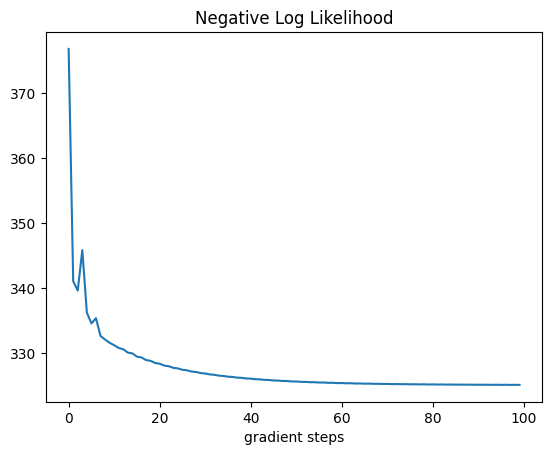

In [22]:
# we are going to be a bit fancy and show an animation of the function as it is being fitted
daily_max = daily_grouped_normalized["max"].values

# use Stochastic gradient descent technique
optimizer = keras.optimizers.legacy.SGD(learning_rate=2e-4)
losses = []

# take an initial GEV distribution
sample_gev = get_gev(xi=-0.1, trainable_xi=True)

fig = plt.figure(dpi=200, figsize=(4.5, 3))
camera = Camera(fig)

for step in range(100):
    # Track operations on tensors inside a with block to calculate the gradient later on
    with tf.GradientTape() as tape:
        # get log likelihood based on the current GEV
        loss = - tf.math.reduce_sum(sample_gev.log_prob(daily_max))
    # now we can extract the gradient from the tape
    gradients = tape.gradient(loss, sample_gev.trainable_variables)
    # do one optimization step
    optimizer.apply_gradients(zip(gradients, sample_gev.trainable_variables))
    # track the losses during iteration process
    losses.append(loss)
    
    # get histogram, not used here
    #bins = plt.hist(daily_max, bins=40, density=True, color="C0")[1]
    #pdf = sample_gev.prob(bins)
    #plt.plot(bins, pdf, color="orange")
    #ax = plt.gca()
    #ax.text(0.5, 1.01, f"{step=}, Loss={loss}", transform=ax.transAxes)
    #camera.snap()

plt.close()
plt.figure()
plt.plot(losses)
plt.title("Negative Log Likelihood")
plt.xlabel("gradient steps")
plt.show()


In [23]:
# maybe not working in VS Code
#animation = camera.animate(interval=100)
#plt.show()

Seems like after 100 steps we have already converged. Let us have a quick look at the result

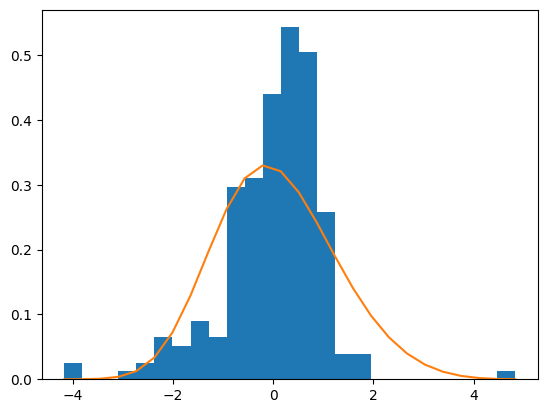

In [24]:
bin_positions = plt.hist(daily_max, density=True, bins=25)[1]
plt.plot(bin_positions, sample_gev.prob(bin_positions))
plt.show()

In [25]:
#HTML(camera.animate().to_html5_video())

In [26]:
# print the estimated parameters
sample_gev.trainable_variables

(<tf.Variable 'xi:0' shape=() dtype=float64, numpy=-0.19605527604088674>,
 <tf.Variable 'mu:0' shape=() dtype=float64, numpy=-0.3901123713168852>,
 <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=1.1369220029896918>)

Well, we probably can do better...

### Your task is now...

Find a better fit using: 
  1. Removing the obvious anomalies
  2. Profiling in the shape parameter $\xi$ or using different initial values/learning rates for inferring $\xi$

Feel free to improve the code by defining new functions and so on!

Evaluate the quality of your fit by visual inspection of a histogram and a Q-Q plot (more on that below).

You can also use other statistical tools that you are familiar with.

Use the fitted model to find "anomalies" for taxi calls corresponding to probabilities of less than $0.01$.

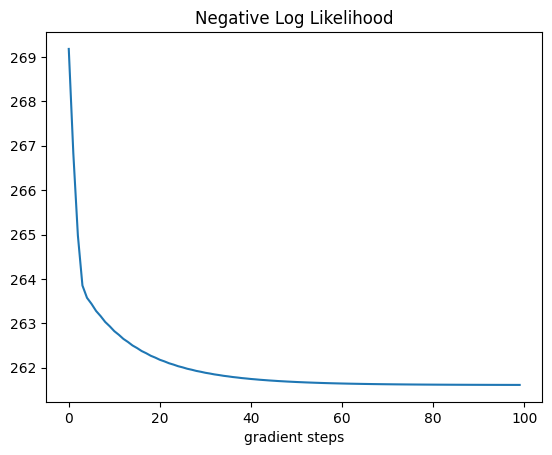

In [27]:
daily_max = daily_grouped_normalized["max"].values
#print(daily_max.size)

# remove outliers
daily_max = np.delete(daily_max, np.where((daily_max > 1.85) | (daily_max <= -3.5))[0])
#print(daily_max.size)

# use Stochastic gradient descent technique
optimizer = keras.optimizers.legacy.SGD(learning_rate=2e-4)
losses = []

# take an initial GEV distribution, estimate xi to -0.6
sample_gev = get_gev(xi=-0.5, trainable_xi=False)

fig = plt.figure(dpi=200, figsize=(4.5, 3))
camera = Camera(fig)

for step in range(100):
    # Track operations on tensors inside a with block to calculate the gradient later on
    with tf.GradientTape() as tape:
        # get log likelihood based on the current GEV
        loss = - tf.math.reduce_sum(sample_gev.log_prob(daily_max))
    # now we can extract the gradient from the tape
    gradients = tape.gradient(loss, sample_gev.trainable_variables)
    # do one optimization step
    optimizer.apply_gradients(zip(gradients, sample_gev.trainable_variables))
    # track the losses during iteration process
    losses.append(loss)

#print(losses)
plt.close()
plt.figure()
plt.plot(losses)
plt.title("Negative Log Likelihood")
plt.xlabel("gradient steps")
plt.show()


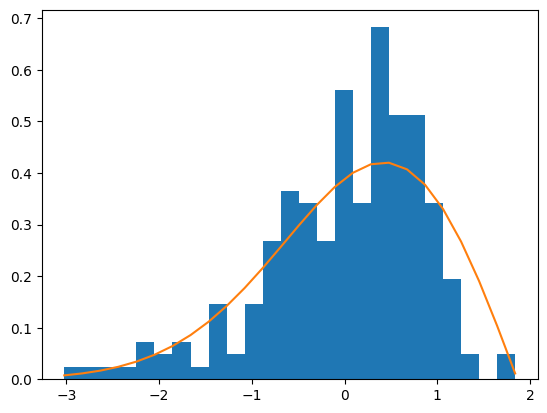

In [28]:
bin_positions = plt.hist(daily_max, density=True, bins=25)[1]
plt.plot(bin_positions, sample_gev.prob(bin_positions))
plt.show()

In [29]:
daily_max = daily_grouped_normalized["max"].values
estimates = sample_gev.prob(daily_max)
#print(estimates)
mask = (estimates < 0.01) 
bools = pd.Series(mask)
#print(bools)
daily_grouped_normalized.loc[bools.values].sort_values(by=['date'])


,max,min,sum,diff
date,,,,
2014-09-06,1.885529,1.328515,1.671843,1.718008
2014-11-02,4.827113,2.561467,0.292112,4.631734
2014-11-27,-3.021224,1.244903,-2.192533,-3.690929
2014-12-25,-4.166655,-1.122790,-3.743349,-4.300615
2015-01-27,-4.010309,-3.442703,-5.330402,-3.482410


### Q-Q Plot

A Q-Q plot is useful for visually comparing two distributions, or comparing a
distribution with a dataset. We are interested in the latter. In a Q-Q plot the
quantiles of one distribution are plotted against the quantiles of another. For
a dataset, the natural choice of quantiles is given simply by the sorted data
itself. The data points then roughly correspond to the $\frac{k}{n+1}$ th
percentiles, where  $n$ is the number of samples and $k=1,...,n$ (these are
often called _plotting positions_ and other choices for them are possible). The
corresponding _theoretical quantiles_ from some specified c.d.f. $F$ are then
given by $q_k \ \text{s.t} \ F(q_k) = \frac{k}{n+1}$ (in our applications, $F$
will generally be injective and the $q_k$ uniquely defined). 


If the distribution is a good fit of the data, the resulting line will be close to the diagonal. Below we ask you to complete a simple implementation of the Q-Q plot for tensorflow-like distributions

In [30]:
ArrayLike = Sequence[Union[float, tf.Tensor]]


class TFDistributionProtocol(Protocol):
    name: str
    trainable_variables: Tuple[tf.Variable]
        
    def quantile(self, prob: ArrayLike) -> ArrayLike: ...    

In [31]:

def qqplot(data: ArrayLike, dist: TFDistributionProtocol):
    num_observations = len(data)
    observed_quantiles = sorted(data)
    plotting_positions = np.arange(1, num_observations + 1) / (num_observations + 1)
    theoretical_quantiles = dist.quantile(plotting_positions)
    
    plot_origin = (theoretical_quantiles[0], observed_quantiles[0])
    plt.plot(theoretical_quantiles, observed_quantiles)
    plt.plot(theoretical_quantiles, theoretical_quantiles) # adding a diagonal for visual comparison
    plt.xlabel(f"Theoretical quantiles of {dist.name}")
    plt.ylabel(f"Observed quantiles")
    

## Solution: MLE for GEV distribution

In [32]:
# setting up functions for normal and profile likelihood fit

def fit_dist(data: ArrayLike, dist: TFDistributionProtocol, num_steps=100, lr=1e-4, 
             plot_losses=True, return_animation=True) -> Union[float, Tuple[float, HTML]]:
    # statistical gradient descent optimizer
    optimizer = keras.optimizers.legacy.SGD(learning_rate=lr)
    losses = []
    
    # setup camera if requested
    if return_animation:
        fig = plt.figure(dpi=200, figsize=(4.5, 3))
        camera = Camera(fig)    

    for step in range(num_steps):
        # Track operations on tensors inside a with block to calculate the gradient later on
        with tf.GradientTape() as tape:
            loss = - tf.math.reduce_sum(dist.log_prob(data))

        # fail early if loss gets NAN
        if np.isnan(loss.numpy()):
            logging.warning(f"Encountered nan after {step} steps")
            break
        
        # do gradient descent step
        gradients = tape.gradient(loss, dist.trainable_variables)
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables))

        # memorize loss in this step
        losses.append(loss)
        
        if return_animation:
            bins = plt.hist(data, bins=50, density=True, color="C0")[1]
            pdf = dist.prob(bins)
            plt.plot(bins, pdf, color="orange")
            ax = plt.gca()
            ax.text(0.5, 1.01, f"{step=}, Loss={round(loss.numpy(), 2)}", transform=ax.transAxes)
            camera.snap()
    

    if plot_losses:
        plt.close()
        plt.figure()
        plt.plot(losses)
        plt.title("Negative Log Likelihood")
        plt.xlabel("gradient steps")
        plt.show()
    
    result = losses[-1]
    if return_animation:
        result = result, HTML(camera.animate().to_html5_video())
    return result

# wrap function around for iterating over several xi's
def profile_fit_dist(data: ArrayLike, dist_factory: Callable[[float], TFDistributionProtocol], xi_values: Sequence[float], 
                     num_steps=100, lr=1e-4) -> Tuple[float, TFDistributionProtocol]:
    """
    Fits the distribution to data and returns the final loss. If return_animation=True, returns the tuple
    (final_loss, animation)
    """
    minimal_loss = np.inf
    optimal_dist = None
    for xi in xi_values:
        # get distribution for current xi
        dist = dist_factory(xi)
        
        # fit model
        loss = fit_dist(data, dist, num_steps=num_steps, lr=lr, plot_losses=False, return_animation=False)

        # check if loss is minimal
        if loss < minimal_loss:
            minimal_loss = loss
            optimal_dist = dist
    if optimal_dist is None:
        raise RuntimeError(f"Could not find optimal dist, probably due to divergences during fit. "  
                           "Try to find a better choice for xi_values")
    return minimal_loss, optimal_dist

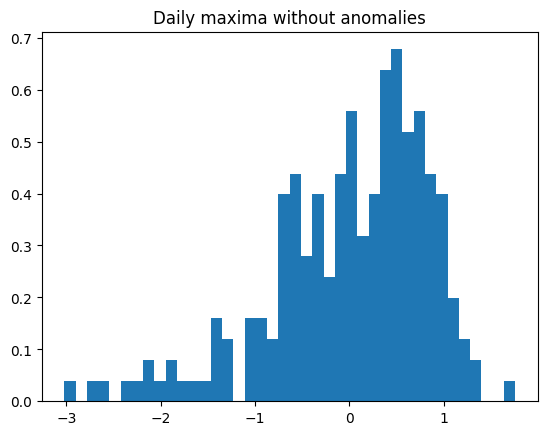

In [33]:
# removing obvious anomalies
daily_max_without_anomalies = daily_max[np.logical_and( daily_max < 1.8, daily_max > -3.5)]

plt.hist(daily_max_without_anomalies, density=True, bins=40)
plt.title("Daily maxima without anomalies")
plt.show()

In [34]:
# Example with profile likelihood
# check 30 different xi values between -0.3 and -0.5
xi_values = np.linspace(-0.3, -0.5, 30)

# lambda function to get different GEV distributions without training xi
dist_factory = lambda xi: get_gev(xi, trainable_xi=False)

# check models for all xi's and return optimal fit
min_loss, optimal_gev = profile_fit_dist(daily_max_without_anomalies, dist_factory, xi_values, num_steps=80)

print(f"Minimal loss: {min_loss}")
print(f"Optimal xi: {optimal_gev.concentration}")
optimal_gev.trainable_variables

Minimal loss: 252.7370856339221
Optimal xi: -0.44482758620689655


(<tf.Variable 'mu:0' shape=() dtype=float64, numpy=-0.2125311941252912>,
 <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=0.896378037612195>)

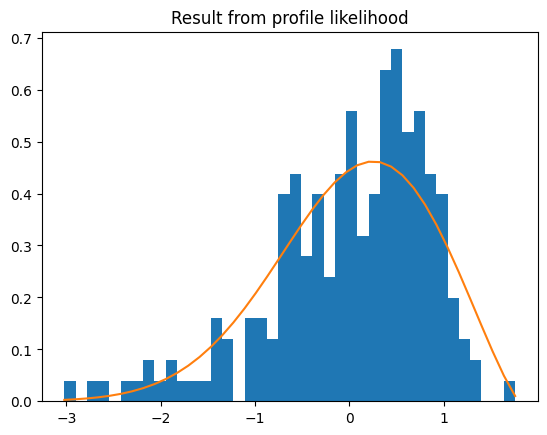

In [35]:
bin_positions = plt.hist(daily_max_without_anomalies, density=True, bins=40)[1]
plt.plot(bin_positions, optimal_gev.prob(bin_positions))
plt.title("Result from profile likelihood")
plt.show()

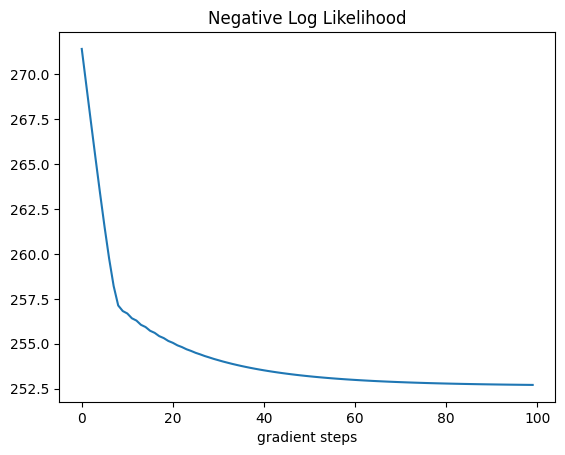

In [36]:
# Solving with gradient descent on best matched xi
daily_max_gev = get_gev(xi=-0.44) # also train xi (?) trainable_xi=True is default
final_loss = fit_dist(daily_max_without_anomalies, daily_max_gev, return_animation=False)

In [37]:
# Here the values found by fitting
daily_max_gev.trainable_variables

(<tf.Variable 'xi:0' shape=() dtype=float64, numpy=-0.44932528677269673>,
 <tf.Variable 'mu:0' shape=() dtype=float64, numpy=-0.21457417383672303>,
 <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=0.9051595209387371>)

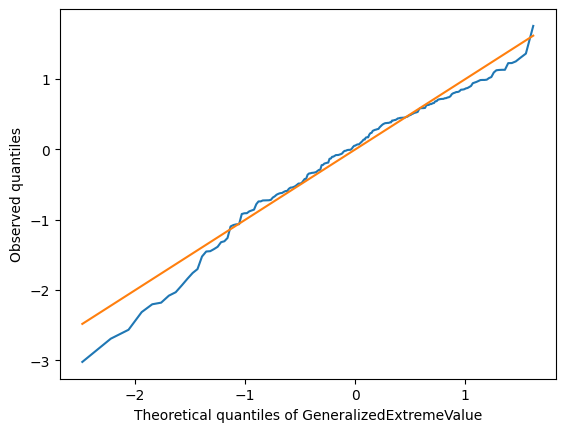

In [38]:
# and here the qqplot
qqplot(daily_max_without_anomalies, daily_max_gev)

### Finding anomalies from the GEV

In [39]:
#The fit looks quite good, apart from the lower region, which we are not really interested in. 
#Let us find the anomalies corresponding to the upper 1% quantile
upper_percentile = 0.99
upper_quantile = daily_max_gev.quantile(upper_percentile).numpy()
upper_quantile

1.5449392940463038

In [40]:
# and here the anomalies above this threshold
daily_grouped_normalized["max"][daily_grouped_normalized["max"] > upper_quantile]

date
2014-07-03    1.756184
2014-09-06    1.885529
2014-11-02    4.827113
2015-01-01    1.839858
Name: max, dtype: float64

In addition to the obvious anomalies found above, we caught the independence day (one day before it). We also have the probabilistic interpretation that for 99% of the days the maximal amount of calls per 30 minutes will not exceed the threshold found above (it should be rescaled back to the original value for this statement to hold).

## Exercise: Estimating the uncertainty

One benefit of the probabilistic approach is that we get confidence intervals almost for free. These can be used to estimate the robustness of our analysis (e.g. the determination of anomalies and the quality of the fit).

Since we fitted our functions using MLE, which is known to be approximately normal, we get uncertainty estimates from the second derivatives of the loss function. Fortunately, tensorflow makes this extremely easy for us.

In [41]:
def observed_fisher_information(data: ArrayLike, dist: TFDistributionProtocol) -> tf.Tensor:
    # Outer gradient tape for second derivatives
    with tf.GradientTape() as t2:

        # Inner gradient tape for first derivatives
        with tf.GradientTape() as t1:
            # total negative log-likelihood (sum of likelihood of each data point)
            nll = - tf.math.reduce_sum(dist.log_prob(data))

        # conversion needed b/c trainable_vars is a tuple, so gradients and jacobians are tuples too
        g = tf.convert_to_tensor(  
            # first derivative with respect to the trainable variables
            t1.gradient(nll, dist.trainable_variables)
        )
    # jacobian of first derivative equals the hessian
    return tf.convert_to_tensor(t2.jacobian(g, dist.trainable_variables))

In [42]:
def mle_std_deviations(data: ArrayLike, dist: TFDistributionProtocol) -> tf.Tensor:
    # get fisher matrix
    observed_information_matrix = observed_fisher_information(data, dist)

    # calculate inverse of fisher matrix to get covariance matrix
    mle_covariance_matrix = tf.linalg.inv(observed_information_matrix)

    # extract diagonal for variance
    variances = tf.linalg.tensor_diag_part(mle_covariance_matrix)
    
    # sqrt to get std deviation
    return tf.math.sqrt(variances)


### Uncertainty Estimation in GEV 

Using the above functions, include error bars into the Q-Q plots of the maximum likelihood estimates of the GEV distribution found above.


## Solution: Estimating the uncertainty

In [43]:
# finding the stddevs and adding/substracting them from the values found from fitting
std_devs = mle_std_deviations(daily_max_without_anomalies, daily_max_gev)
print(f"Found std_devs: {std_devs}")

coeff_fitted = tf.convert_to_tensor(daily_max_gev.trainable_variables)
coeff_upper = coeff_fitted + std_devs
coeff_lower = coeff_fitted - std_devs

# creating GEVs corresponding to the boundaries of the confidence intervals found above
gev_upper = get_gev(*coeff_upper)
gev_lower = get_gev(*coeff_lower)

Found std_devs: [0.02619854 0.06607506 0.04557824]


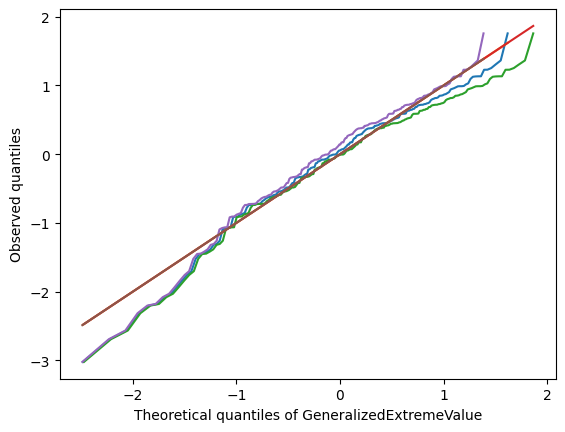

In [44]:
# The qqplots for the original GEV and the GEVs at the boundaries

qqplot(daily_max_without_anomalies, daily_max_gev)
qqplot(daily_max_without_anomalies, gev_upper)
qqplot(daily_max_without_anomalies, gev_lower)

## Exercise: GEV for daily minima

Now let us repeat the same analysis fitting the distribution of the daily minima using the same strategy. Since minima for a univariate random variable $X$ correspond to maxima of $-X$, all we have to do is to fit a GEV to the minima multiplied by -1.

## Solution: GEV for daily minima

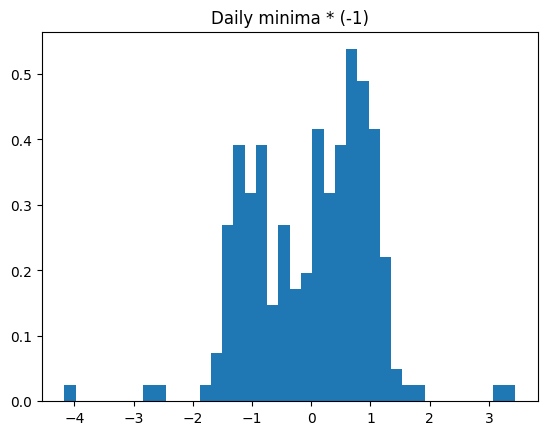

In [45]:
# use min column of the data (grouped by min column) and negate values
neg_minima_series = -daily_grouped_normalized["min"]
# convert series to array
neg_daily_min = neg_minima_series.values

# plot (normalized!) negated values (x-axes is flipped by multiplication by -1)
plt.hist(neg_daily_min, density=True, bins=40)
plt.title("Daily minima * (-1)")
plt.show()

In [46]:
# identifying obvious anomalies according to histogram
neg_minima_series[(neg_minima_series>2) | (neg_minima_series<-2)]

date
2014-11-01   -4.168684
2014-11-02   -2.561467
2015-01-01   -2.683568
2015-01-26    3.202483
2015-01-27    3.442703
Name: min, dtype: float64

In [47]:
# - 01/01 - New Year
# - 01-02/11 - Marathon
# - 26-27/01 - Snowstorm

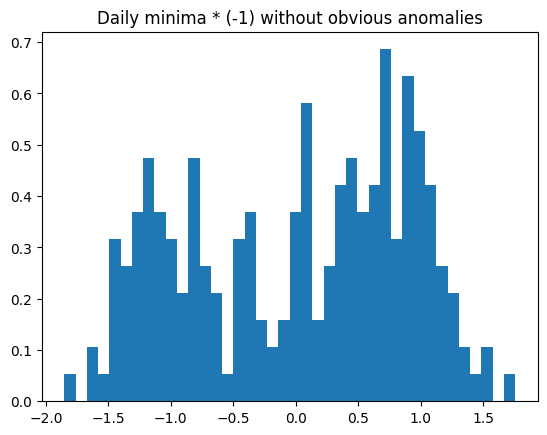

In [48]:
# remove the anomalies as seen in the histogram
neg_minima_without_anomalies = neg_daily_min[np.logical_and(neg_daily_min<2, neg_daily_min>-2)]

# plot histogram without anomalies
plt.hist(neg_minima_without_anomalies, density=True, bins=40)
plt.title("Daily minima * (-1) without obvious anomalies")
plt.show()

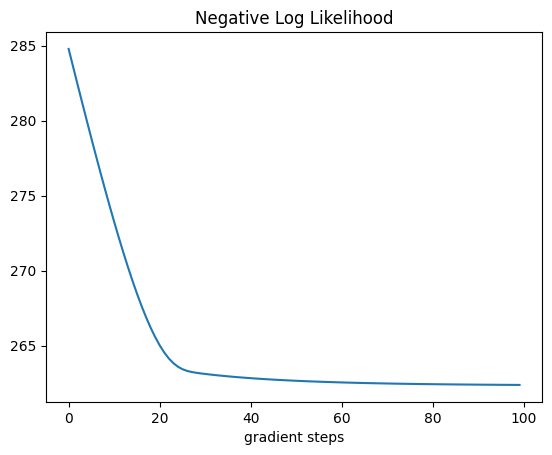

In [49]:
# get distribution to start with, all variables trainable
daily_min_gev = get_gev(xi=-0.3)

# fit distribution and find optimal distribution parameters, 100 iterations default
# no hyper-parameter optimization for xi
final_loss = fit_dist(neg_minima_without_anomalies, daily_min_gev, return_animation=False)

# with xi optimization
#xi_values = np.linspace(-0.1, -0.5, 30)
#dist_factory = lambda xi: get_gev(xi, trainable_xi=False)
#final_loss = profile_fit_dist(neg_minima_without_anomalies, dist_factory, xi_values)

In [50]:
#final_loss[0].numpy()
daily_min_gev.trainable_variables

(<tf.Variable 'xi:0' shape=() dtype=float64, numpy=-0.45057713338539956>,
 <tf.Variable 'mu:0' shape=() dtype=float64, numpy=-0.20803571235882318>,
 <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=0.9218074199211737>)

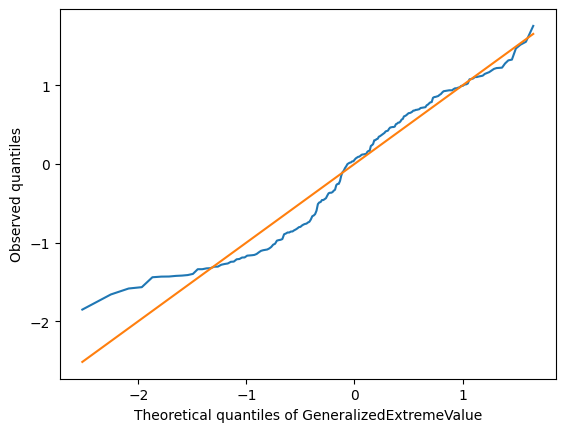

In [51]:
qqplot(neg_minima_without_anomalies, daily_min_gev)

In [52]:
# Fit looks good in the region we are interested in, let us find the 1% quantile and the corresponding anomalies

In [53]:
upper_quantile = daily_min_gev.quantile(0.99).numpy()
upper_quantile

1.5803475989870677

In [54]:
neg_minima_series[neg_minima_series>upper_quantile]

date
2015-01-26    3.202483
2015-01-27    3.442703
2015-01-28    1.755855
Name: min, dtype: float64

In [55]:
# Only one non-obvious anomaly is found in the upper quantile, it is cause by the snowstorm responsible for the obvious anomalies we have seen above.

## Example: Comparison with the Z-Test

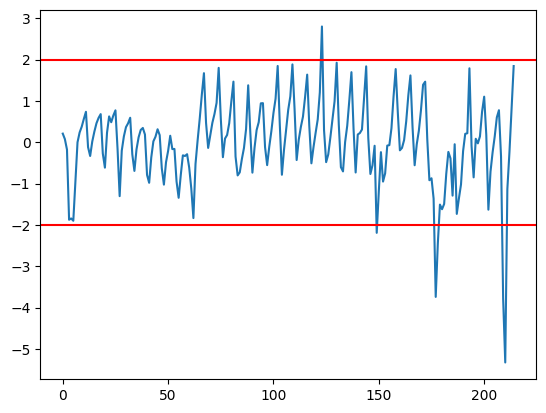

In [56]:
daily_means = daily_grouped_normalized["sum"]

plt.plot(daily_means.values)
plt.axhline(y=2., color='r', linestyle='-')
plt.axhline(y=-2., color='r', linestyle='-')
plt.show()

The big question here is: where to put the threshold? Clearly the assumption of a Gaussian distribution underlying the sum of daily calls is incorrect - the distribution seems skewed.

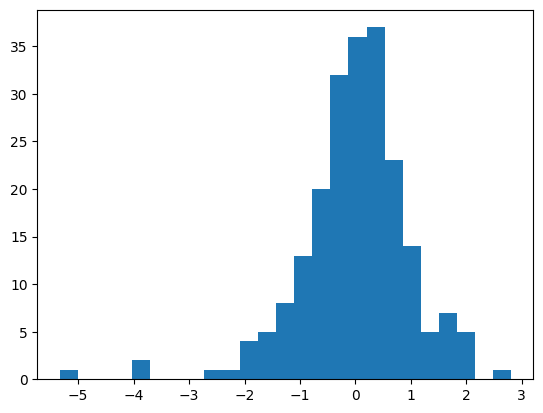

In [57]:
plt.hist(daily_means, bins=25)
plt.show()

We can detect some anomalies with the Z-test, of course, but the probabilistic interpretation is going to be flawed.

In [58]:
daily_means[np.abs(daily_means) > 2]

date
2014-11-01    2.802000
2014-11-27   -2.192533
2014-12-25   -3.743349
2014-12-26   -2.452098
2015-01-26   -3.786365
2015-01-27   -5.330402
Name: sum, dtype: float64

## Exercise (theoretical, bonus): Proofing the Fisher-Gnedenko-Tripet theorem

One may wonder how the statement of the Fisher-Gnedenko-Tripet theorem is obtained without providing bounds on convergence. The reason is that the limiting distribution of (renormalized) maxima must have a very special property - it must be max stable. It is instructive to go through a part of the proof to get a feeling for the EVT theorems. We will do so in this exercise.


__Definition__: A cumulative distribution function $D(z)$ is called _max-stable_ iff for all $n\in\mathbb{N} \ \exists \ \alpha_n>0, \beta_n \in  \mathbb{R}$ such that 

$$
D^n(z) = D(\alpha_n z + \beta_n)
$$

Prove that from $\lim_{n\rightarrow \infty} P\left( \frac{M_n - b_n}{a_n} < z \right) = G(z)$ follows that $G(z)$ is max-stable.

This goes a long way towards proving the first EVT theorem. One can easily compute that the GEV distribution is max-stable and with more effort one can also prove that any max-stable distribution belongs to the GEV family. Thus, the proof of the theorem is very implicit and does not involve any convergence rates or bounds.

## Exercise: Increasing the block size

According to the line of thought above, increasing the block-size before determining the maxima should improve convergence. Of course, it also decreases the number of points for fitting so it increases variance. We will analyze uncertainties of the fitted GEV below.

Repeat the fit of the GEV for 2-day maxima/minima. What do you think about the result?

_Hint: use the .reshape method of numpy arrays on the already computed daily maxima/minima_

## Solution: Increasing the block size

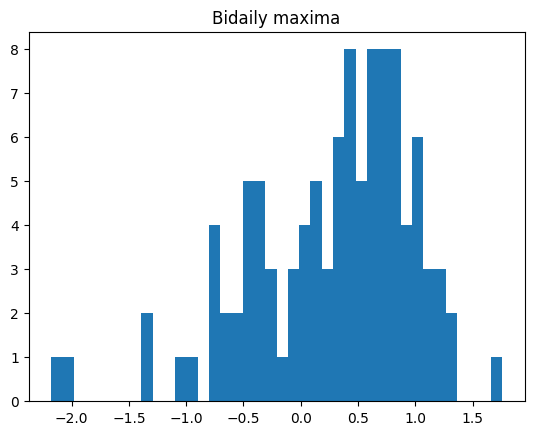

In [59]:
# reshape a column with even number of rows to two columns, then max along the horizontal row
bidaily_maxima = daily_max_without_anomalies.reshape(-1, 2).max(axis=1)

# plot histogram
plt.hist(bidaily_maxima, bins=40)
plt.title("Bidaily maxima")
plt.show()

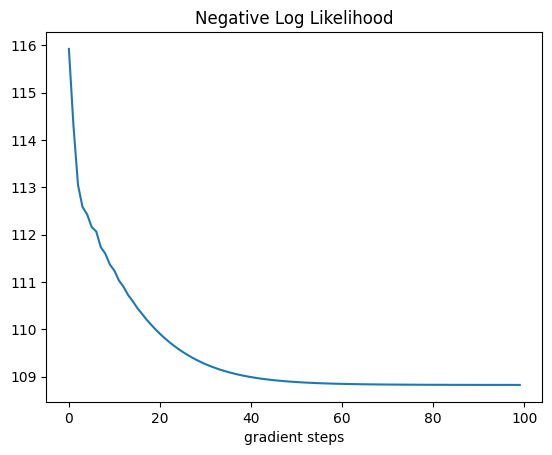

In [60]:
bidaily_gev = get_gev(xi=-0.5)
loss = fit_dist(bidaily_maxima, bidaily_gev, lr=3e-4, num_steps=100, return_animation=False)

In [61]:
bidaily_gev.trainable_variables

(<tf.Variable 'xi:0' shape=() dtype=float64, numpy=-0.43521712704950993>,
 <tf.Variable 'mu:0' shape=() dtype=float64, numpy=0.07379174390548407>,
 <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=0.7643633709060534>)

The shape parameter xi should be independent of the size of the block (xi is not affected by $a_n$ and $b_n$) .
Of course, since we find xi from fitting, we shouldn't be surprised to find a slightly different value.

We get a better fit than before (less than half of the loss with half as many data points). 
But we have higher variance in the very important shape parameter $\xi$

In [62]:
std_devs_daily = mle_std_deviations(daily_max_without_anomalies, daily_max_gev)
std_devs_bidaily = mle_std_deviations(bidaily_maxima, bidaily_gev)

print("Daily stddevs:")
print(std_devs_daily.numpy())
print("Biaily stddevs:")
print(std_devs_bidaily.numpy())

Daily stddevs:
[0.02619854 0.06607506 0.04557824]
Biaily stddevs:
[0.03952068 0.07958698 0.05549258]


## Exercise (theoretical, bonus): Peaks over threshold (PoT)
### Deriving the second theorem of EVT

So far we have only used the first theorem of EVT. As you might have noticed above, it can be somehow wasteful when it comes to data efficiency. Since the GEV is fitted on block-maxima, a huge number of data points remain unused for parameter estimation. The second theorem of EVT gives rise to a more efficient approach

Use the approximation $\ln(1+x) \approx 1 + x$ for $|x| \ll 1$ and $F(z) \approx 1$ for large enough $z$ to derive.

\begin{align}
P(X-u < y \mid X > u) &\approx 1 - \left( 1 + \frac{\xi \ y}{\tilde{\sigma}} \right)^{-\frac{1}{\xi}} 
\end{align}

for large enough $u$ (this is a slightly less formal derivation of Pickards' et. al. theorem). One could equivalently write

\begin{equation}
P(X-u > y \mid X > u) \approx \left( 1 + \frac{\xi \ y}{\tilde{\sigma}} \right)^{-\frac{1}{\xi}}
\end{equation}



What is the relation between $\tilde{\sigma}$ and the normalizing coefficients of the first theorem of EVT?

The above equation can be used to estimate the entire tail of the cdf $F$ of $X$ from a sample of size $N$ obtained by sampling repeatedly from $F$. First note that for a single $u$ we can approximate the cdf through the sample statistics as:


\begin{equation}
1-F(u) = P(X>u) \approx \frac{N_u}{N}
\end{equation}

where $N_u$ is the number of samples with values above $u$. Interpreting $u$ as a threshold, we will call those samples _peaks over threshold_ (PoT) and $N_u$ is simply their count.

__Q__: What should $u$ and the data set fulfill in order for the above approximation to be accurate?

__A__: It should be small enough such that many data points are larger than it. Then the approximation in $P(X>u) \approx \frac{N_u}{N}$ holds (the estimator is not too biased). 

Now we can perform a series of approximations for $z>u$ to get to the tail-distribution. First using $P(X>u) \approx \frac{N_u}{N}$ we get

\begin{align}
P(X>z) &= P(X>z \cap X>u)  \\
&= P(X>z \mid X>u) P(X>u)  \\
&\approx \frac{N_u}{N} P(X>z \mid X>u)
\end{align}


Now we use the GDP theorem to approximate

\begin{align}
P(X>z \mid X>u) &= P(X-u > z -u \mid X>u)  \\
&\approx \left( 1 + \frac{\xi (z-u)}{\tilde{\sigma}} \right)^{-\frac{1}{\xi}}
\end{align}


Putting everything together gives

$$
P(X>z) \approx \frac{N_u}{N}  \left( 1 + \frac{\xi (z-u)}{\tilde{\sigma}} \right)^{-\frac{1}{\xi}}
$$

__Q__: Intuitively, what does $u$ need to fulfill for both approximations to hold?

__A__: $u$ should be small enough such that the approximation $P(X>u) \approx \frac{N_u}{N}$ holds and sufficiently large such that the generalized pareto distribution is a good estimate of the tail of the distribution for values larger than $u$. Intuitively, it should be at the *beginning of the tail*, where for values larger than $u$ only the tail behavior plays a role - i.e. no more local extrema or other specifics of the underlying distribution of the data. 

## Exercise: GPD for Anomaly Detection

This exercise lets you explore the second theorem of EVT for anomaly detection. Here we let you calculate and code on your own, without giving too many hints. You can follow the GEV-fitting code above for solving this exercise. Feel free to ask for hints if you are stuck!

1. Using the results above, find an approximation of the upper quantile $z_q$ such that $P(X>z_q) < q$ (assuming $z_q > u$).
2. What is the relation of this quantile to the quantile of the generalized pareto distribution?
3. Select a threshold $u$ and fit the generalized pareto distribution to the peaks over this threshold using tensorflow-probability and the same tricks that were used above for fitting the GEV distribution. You might want to use the profile likelihood fitting.
4. Determine anomalies from the quantile function.
5. What advantages do you see in fitting the GPD with PoT compared to fitting GEV distribution using block-maxima for anomaly detection? What are the disadvantages?
6. Check the quality of your fit and perform an uncertainty analysis as above for the GEV.

## Solution: GPD for Anomaly Detection

In [305]:
# We define the creation of the GPD (generalized pareto distribution) analogous to the GEV above
def get_gpd(xi: float,  sigma=1., trainable_xi=True):
    # two parameters, xi and sigma
    xi, sigma = np.array([xi, sigma]).astype(float)
    if trainable_xi:
        xi = tf.Variable(xi, name="xi")

    # return GPD
    return tfd.GeneralizedPareto(
        loc=loc,
        scale=tf.Variable(sigma, name='sigma'),
        concentration=xi
    )

In [64]:
# GPD is fit directly on the thresholded data, no need for grouping
n_calls = taxi_df_normalized["n_calls"].values

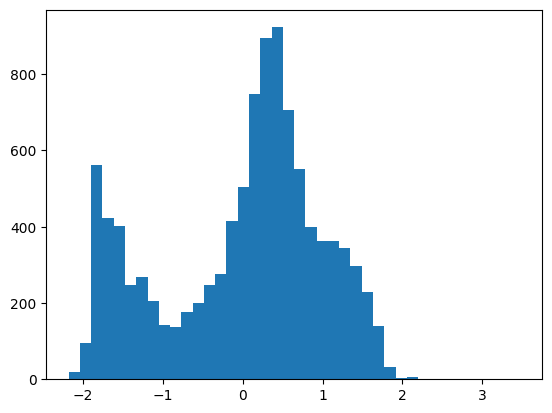

In [65]:
# plot histogram
plt.hist(n_calls, bins=40)
plt.show()

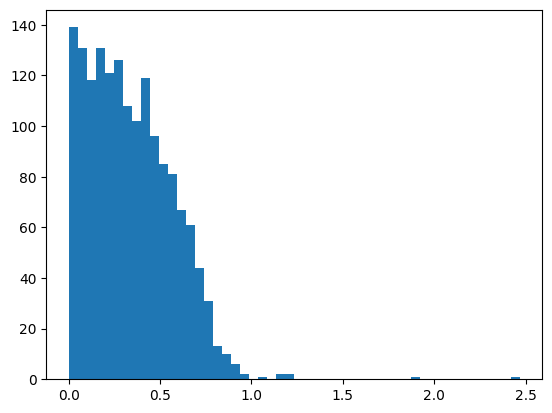

In [66]:
# seems like u=1 gives a good value for the beginning of "tail behaviour"
u = 1

# extract the tail and calculate excess (above u)
thresholded_n_calls = n_calls[n_calls>u] - u

# check histogram
plt.hist(thresholded_n_calls, bins=50)
plt.show()

In [67]:
# obvious anomalies above 1 (above u)
taxi_df_normalized[taxi_df_normalized["n_calls"]> u+1]

,n_calls,time,date
134,2.139658,19:00:00,2014-07-03
3261,2.186926,22:30:00,2014-09-06
3262,2.195573,23:00:00,2014-09-06
5954,3.467197,01:00:00,2014-11-02
5955,2.892920,01:30:00,2014-11-02
8833,2.076538,00:30:00,2015-01-01
8834,2.175830,01:00:00,2015-01-01


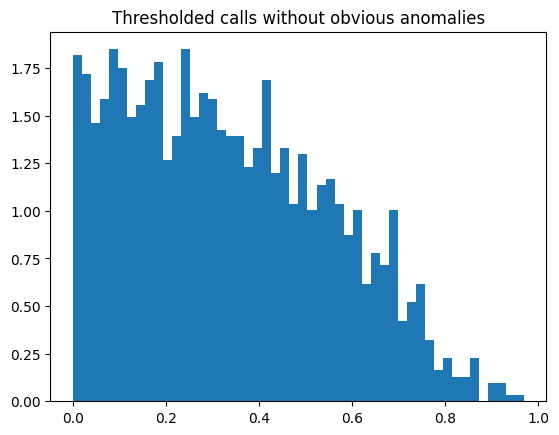

In [68]:
# we filter out some calls on (one day before) independence day, Columbus day, the marathon and New Year
cleaned_thresholded_calls = thresholded_n_calls[thresholded_n_calls < 1]

# check histogram without the obvious anomalies
plt.hist(cleaned_thresholded_calls, bins=50, density=True)
plt.title("Thresholded calls without obvious anomalies")
plt.show()

In [144]:
cleaned_thresholded_calls.shape

(1591,)

Using xi=-0.44932528677269673


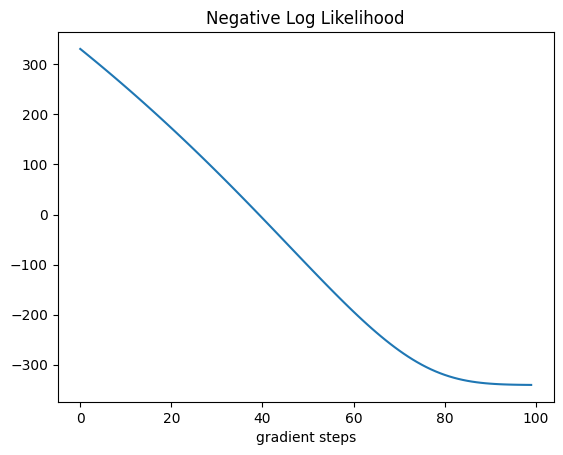

In [125]:
# fitting the gpd. We need a small lr (learning rate) to not hit singularities
# We bypass fitting xi here, instead using the xi found from fitting the GEV above. 
# Theory suggests that it should be close to the optimal value. 
# We could also profile around it or try full gradient, of course. The latter is brittle

# steal xi from previous exercise
xi_gev = daily_max_gev.concentration.numpy()
print(f"Using xi={xi_gev}")

# get the GPD with the previous xi and train sigma
gpd = get_gpd(xi=xi_gev, sigma=1, trainable_xi=False)

# fit with a small learning rate
loss = fit_dist(cleaned_thresholded_calls, gpd, lr=5e-6, num_steps=100, return_animation=False)

In [238]:
#gpd.parameters
cleaned_thresholded_calls.shape

(1591,)

In [300]:
# now the Q-Q plot and the stddev

# stddev via fisher information matrix
std = mle_std_deviations(cleaned_thresholded_calls, gpd)

# lay a tube with 2 sigma around the found distribution
fitted_coeff = tf.convert_to_tensor(gpd.trainable_variables)
coeff_upper = fitted_coeff + std
coeff_lower = fitted_coeff - std

# and fetch the GPD, unpack the coeff array to single parameters
gpd_upper = get_gpd(gpd.concentration.numpy(), *coeff_upper.numpy())
gpd_lower = get_gpd(gpd.concentration.numpy(), *coeff_lower.numpy())

In [301]:
fitted_coeff.numpy()

array([0.45112144])

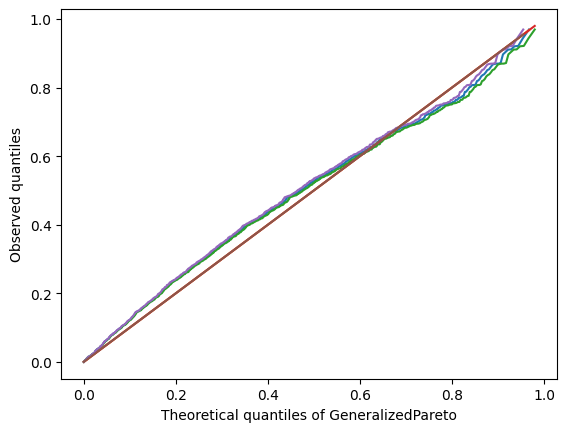

In [302]:
# Q-Q plot the three distributions
qqplot(cleaned_thresholded_calls, gpd)
qqplot(cleaned_thresholded_calls, gpd_upper)
qqplot(cleaned_thresholded_calls, gpd_lower)

In [73]:
# finding the threshold corresponding to probability of 0.01 of the non-conditioned tail
# For that, we rescale with our estimate of N_u

N_u = len(cleaned_thresholded_calls)/len(thresholded_n_calls)

# P(X < z) = 1 - P(X > z)
percentile = 1 - N_u * 0.01

# number calls = u + excess
q = u + gpd.quantile(percentile).numpy()
q

1.8774581734227378

In [74]:
# and the anomalies lying above it. We find the same ones
#n_calls = taxi_df_normalized["n_calls"]
taxi_df_normalized[taxi_df_normalized["n_calls"] > q]

,n_calls,time,date
134,2.139658,19:00:00,2014-07-03
3261,2.186926,22:30:00,2014-09-06
3262,2.195573,23:00:00,2014-09-06
3263,1.920468,23:30:00,2014-09-06
5279,1.943813,23:30:00,2014-10-18
5942,1.910956,19:00:00,2014-11-01
5954,3.467197,01:00:00,2014-11-02
5955,2.892920,01:30:00,2014-11-02
6959,1.921620,23:30:00,2014-11-22
8833,2.076538,00:30:00,2015-01-01


### Results:

We found new candidates for anomalies (or rare events). The 10.01.2015 was the day following Charlie Hebdo related terrorist attacks, there was a large march in Paris. Maybe there was additional movement across New York's large Jewish community. See e.g. [this article](https://www.vogue.com/article/jesuischarlie-new-york-demonstration-charlie-hebdo)

We could not find events that could have caused the large numbers of calls on the 18/10/2014 and the 22/11/2014.

We also now have a probabilistic model for the tail of n_calls/30 minutes which might be useful for planning taxi availabilities on a more granular level than just per-day. 

## Exercise: Anomaly Detection with EVT

Using the anomaly scores from a data set and algorithm from yesterday (you can choose your favorite), perform an EVT analysis along the lines of what was done above. What are your conclusions? In which situations can such an analysis be useful in practical situations? 

## Solution: Anomaly Detection with EVT
Left to the reader

In [264]:
#csv = os.path.join("..", 'data','stocks','edf_stocks.csv')
#df = pd.read_csv(csv, sep = ",")
# convert date
#df['DATE'] = df['DATE'].apply(pd.to_datetime)
# drop unneeded columns
#df.drop(df.columns[0], axis=1, inplace=True)
#df.drop(columns=["VOLUME"], inplace=True)

# Use dataset with rainfall
csv = os.path.join("..", 'data','rainfall','rain.dat')
with open(csv, 'r') as file:
    content = file.read()
# Split by commas
data = content.split(',')
# Create a DataFrame with one column
df = pd.DataFrame(map(float, data), columns=['Values'])

#csv = os.path.join("..", 'data','syn_flood','mawi_180812_50_50.csv')
#df = pd.read_csv(csv, sep = ",")
#df.columns.values[0] = 'no'
#norm_df = df[["no", "packet_rate", "avgPktsSize", "nAttacks", "nFlows"]]
#norm_df["packet_rate"] = normalize(df["packet_rate"])


df = df * 1000000
df.head(100)

,Values
0,0.1
1,0.1
2,0.3
3,0.3
4,0.3
...,...
95,0.1
96,0.1
97,0.1
98,0.1


In [265]:
df.describe()

,Values
count,21915.000000
mean,10.723737
std,20.093674
min,0.000000
25%,0.100000
50%,2.500000
75%,11.500000
max,243.800000


In [266]:
df.dtypes

Values    float64
dtype: object

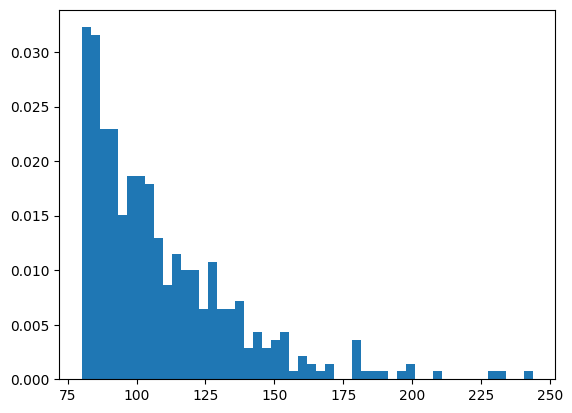

In [267]:
plt.close()
#plt.hist(df[df["CLOSE"] > 9.65]["CLOSE"], bins=50, density=True)
plt.hist(df[df["Values"]>80], bins=50, density=True)
#plt.title("packet_rate")
plt.show()

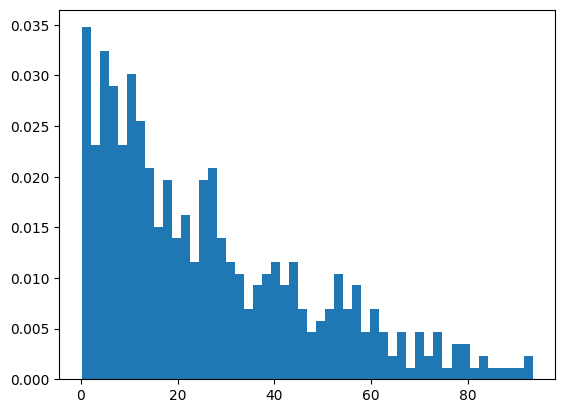

(463,)


In [ ]:
# get the tail
plt.close()
#ser = df[df["CLOSE"] > 9.66]["CLOSE"] - 9.66

# get data tail and shift data to the left!!
uu = 76
arr = df[(df["Values"]>76) & (df["Values"] < 170)] - uu
arr = arr.values.flatten()
plt.hist(arr, bins=50, density=True)
plt.show()
print(arr.shape)

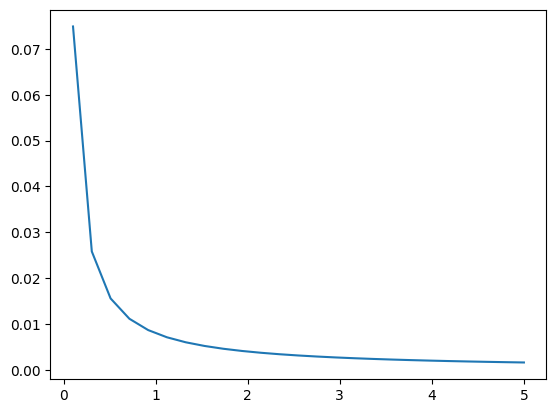

In [ ]:
# do some sample plots of distributions
gpd2 = get_gpd(xi=120, sigma=0.8, trainable_xi=True)
def plot_distribution(gev):
    arr = np.linspace(-5, 5)

    pdf = gev.prob(arr)
    plt.plot(arr, pdf)
    plt.show()
plot_distribution(gpd2)

In [269]:
# estimate starting parameters
mean_excess = np.mean(arr)
var_excess = np.var(arr)
xi_start = (mean_excess ** 2) / (2 * var_excess) - 1
xi_start

-0.2540577211837741

In [270]:
# estimate starting parameters
from scipy.stats import genpareto
shape, loc, scale = genpareto.fit(arr)
print("Initial xi estimate:", shape)
print("Initial loc estimate:", loc)
print("Initial mu estimate:", scale)

Initial xi estimate: -0.30812924066008507
Initial loc estimate: 0.19999999599124252
Initial mu estimate: 34.75139675502196


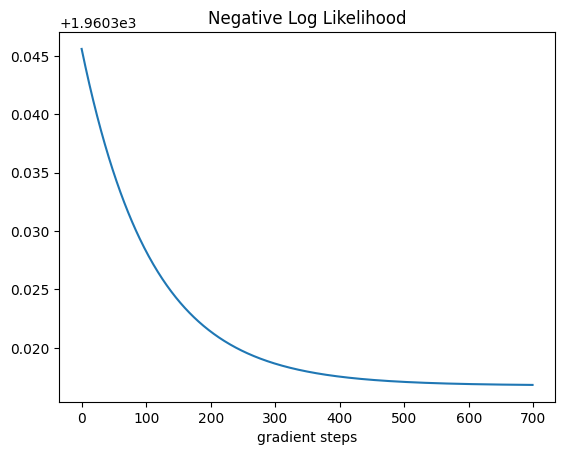

{'loc': 0.19999999599124252,
 'scale': <tf.Variable 'sigma:0' shape=() dtype=float64, numpy=34.241251992442606>,
 'concentration': -0.3,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': None}

In [373]:

#gpd2 = get_gpd(xi=-0.3, sigma=34, trainable_xi=True)
gpd2 = get_gpd(xi=-0.3, sigma=34, trainable_xi=False)

# fit with a small learning rate
loss = fit_dist(arr, gpd2, lr=5e-3, num_steps=700, return_animation=False)
gpd2.parameters

In [374]:
loss

<tf.Tensor: shape=(), dtype=float64, numpy=1960.3168230073932>

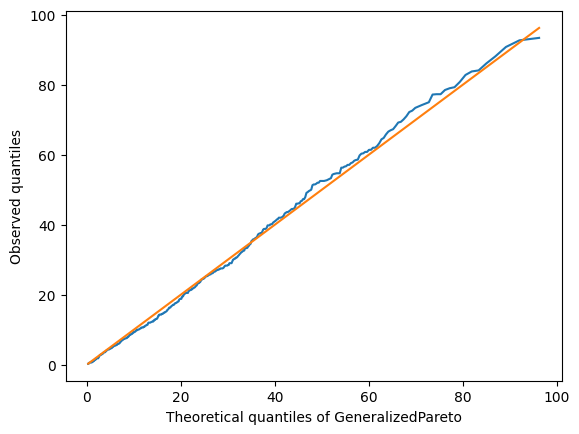

In [375]:
qqplot(arr, gpd2)

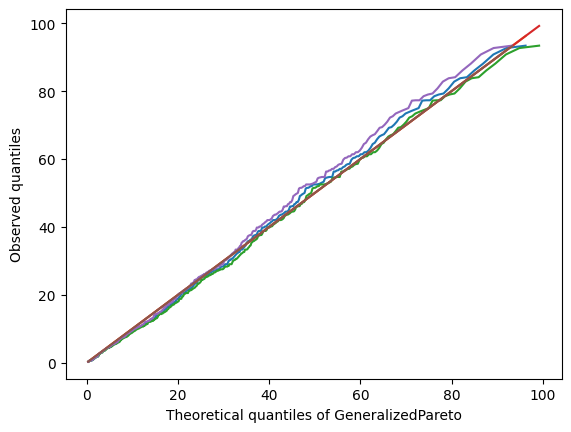

In [376]:
# stddev via fisher information matrix
std2 = mle_std_deviations(arr, gpd2)

# lay a tube with 2 sigma around the found distribution
fitted_coeff2 = tf.convert_to_tensor(gpd2.trainable_variables)
coeff_upper2 = fitted_coeff2 + std2
coeff_lower2 = fitted_coeff2 - std2

# and fetch the GPD, unpack the coeff array to single parameters
#gpd_upper2 = get_gpd(gpd2.concentration.numpy(), *coeff_upper2.numpy()) # if xi not trainable
gpd_upper2 = get_gpd(gpd2.concentration.numpy(), *coeff_upper2.numpy())
gpd_lower2 = get_gpd(gpd2.concentration.numpy(), *coeff_lower2.numpy())

# Q-Q plot the three distributions
qqplot(arr, gpd2)
qqplot(arr, gpd_upper2)
qqplot(arr, gpd_lower2)

In [377]:
# finding the threshold corresponding to probability of 0.01 of the non-conditioned tail
# For that, we rescale with our estimate of N_u

N_u = len(arr)/df.shape[0]

# P(X < z) = 1 - P(X > z)
percentile = 1 - N_u * 0.01

# number calls = u + excess
q = uu + gpd2.quantile(percentile).numpy()
q

181.32428115525246

In [ ]:
# Which heavy rainfalls occured by less than 1%?
df[df["Values"] > q]

,Values
867,183.1
1707,190.7
4240,198.3
5372,197.3
6827,231.1
8254,229.3
8958,243.8
11615,210.6
12215,198.3
15618,186.5


In [367]:
max(df["Values"])

243.79999999999998

<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention, this concludes the A.D. training. </div>
<div class="md-slide title">We will be happy to see you in another Transferlab training soon!</div>